## Fig S16: Noise from experimental procedures in the Reg-Seq pipeline

Required packages:

In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt

fdir = '../data/'
out_fdir = '../plots/figS16/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

Similarly, we read in the experimentally determined energy matrix for the lacI repressor (Barnes et al., 2019) and normalize the energy matrix.

In [5]:
O1_1027_raw = np.load(fdir + 'energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### 1. Simulating noise from PCR amplification

In order to simulate experimental noise from PCR amplification, we define the following two functions.

In [6]:
def amplify(seq_cnt, rounds, p_amp=0.5):
    """
    Simulates PCR amplification using a binomial process.

    Args:
        seq_cnt (int): Initial DNA count.
        rounds (int): Number of amplification rounds.
        p_amp (float, optional): Probability of amplification for each DNA molecule per round. Defaults to 0.5.

    Returns:
        int: Amplified DNA count after the specified number of rounds.
    """
    for round in range(rounds):
        seq_cnt = seq_cnt + np.random.binomial(seq_cnt, p_amp)
    return seq_cnt

def append_amplified_count(original_count, rounds):
    """
    Simulates PCR and returns the amplified DNA count.

    Args:
        original_count (int): Initial DNA count to amplify.
        rounds (int): Number of amplification rounds.

    Returns:
        int: Amplified DNA count after the specified number of rounds.
    """
    return amplify(original_count, rounds)

For convenience, we define the function below `get_signal` where we calculate the average mutual information at a binding site given the footprint and the left and right indices of the binding site.

In [7]:
def get_signal(footprint, region_param):
    """
    Calculate the total mutual information within a binding site and the length of the binding site.

    Parameters:
    ----------
    footprint : array-like
        Array containing mutual information of a promoter.
    region_param : tuple of int
        Tuple specifying the start and end indices (inclusive) of the binding site.

    Returns:
    -------
    signal : float
        The sum of the mutual information within the binding site.
    length : int
        The length of the binding site.
    """
    signal = np.sum(footprint[(region_param[0]+115):(region_param[1]+116)])
    length = region_param[1] - region_param[0] + 1
    return signal, length

For each inducer concentration, we simulate 20 synthetic datasets in order to observe the average effects. To save computational time, we first generate 20 mutant libraries beforehand using the function `mutations_rand`.

In [8]:
mutant_bank = []
for i in range(20):
    mutants = np.unique(tregs.wgregseq.mutations_rand(promoter,
                                                rate=0.1,
                                                num_mutants=5000,
                                                number_fixed=True,
                                                keep_wildtype=True))
    mutant_bank.append(mutants)

We define the usual parameters needed for a simple repression thermodynamic model and we build synthetic datasets for each of the 20 pre-generated synthetic datasets. Afterwards, we simulate PCR on the RNA count of the synthetic datasets and we re-calculate the normalized RNA count.

In [9]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15

l_rounds = np.arange(1, 31, 1)
l_stn_ratio_rnap10 = []
l_stn_ratio_rnap35 = []
l_stn_ratio_lacI = []
for rounds in l_rounds:
    rnap10 = []
    rnap35 = []
    lacI = []
    for j in range(20):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                                *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                                preset_mutants=mutant_bank[i])
        df['ct_1_amplified'] = df.apply(lambda row: append_amplified_count(row['ct_1'], rounds), axis=1)
        df['ct_1_amplified'] = df['ct_1_amplified'] / max(df['ct_1_amplified']) * 10**4
        df['norm_ct_1'] = df['ct_1_amplified'] / df['ct_0']
        
        nbins = 2
        mut_list = df['seq'].values
        mu_data = df['norm_ct_1']
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
        
        region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
        rnap35_signal, rnap35_length = get_signal(footprint, region_params[0])
        rnap10_signal, rnap10_length = get_signal(footprint, region_params[1])
        lacI_signal, lacI_length = get_signal(footprint, region_params[2])

        total_signal = rnap35_signal + rnap10_signal + lacI_signal
        total_noise = np.sum(footprint) - total_signal
        mean_noise = total_noise / (160 - (rnap35_length + rnap10_length + lacI_length))
        
        rnap10.append(rnap10_signal / rnap10_length / mean_noise)
        rnap35.append(rnap35_signal / rnap35_length / mean_noise)
        lacI.append(lacI_signal / lacI_length / mean_noise)
    l_stn_ratio_rnap10.append(np.mean(rnap10))
    l_stn_ratio_rnap35.append(np.mean(rnap35))
    l_stn_ratio_lacI.append(np.mean(lacI))

We plot the signal-to-noise ratio of the information footprints against the number of PCR cycles.

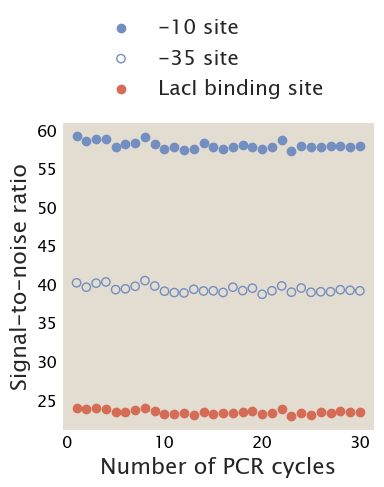

In [10]:
fig, ax = plt.subplots(figsize=(4, 5.5))
ax.scatter(l_rounds, l_stn_ratio_rnap10, label='-10 site', color='#738FC1')
ax.scatter(l_rounds, l_stn_ratio_rnap35, label='-35 site', facecolors='none', edgecolors='#738FC1', )
ax.scatter(l_rounds, l_stn_ratio_lacI, label='LacI binding site',
           color='#D56C55')
ax.set_xlabel('Number of PCR cycles', fontsize=16)
ax.set_ylabel('Signal-to-noise ratio',fontsize=16)
ax.legend(bbox_to_anchor=(0.9, 1.4), frameon=False, fontsize=15)

plt.tight_layout()
plt.savefig(out_fdir + 'amplification_bias.pdf')

### 2. Simulating noise from random sampling effects

Next, we simulate the noise from random sampling effects during mRNA extraction, reverse transcription, and next generation sequencing.

In [11]:
def random_sampling(df, n=10**5):
    """
    Randomly sampling rows from a DataFrame.

    Args:
        df (pandas.DataFrame): The input synthetic dataset.
        n (int, optional): The number of random samples to select. Defaults to 10**5.

    Returns:
        pandas.DataFrame: A new DataFrame containing `n` randomly sampled rows.
    """
    df_large = df.loc[df.index.repeat(df.ct_1)]
    
    df_random = df_large.sample(n=n).drop_duplicates()
    return df_random

We define the usual parameters needed for a simple repression thermodynamic model and we build synthetic datasets for each of the 20 pre-generated synthetic datasets. We perform random sampling on the resulting synthetic datasets and we vary the degree of random sampling effects by changing the number of random samples being drawn.

In [12]:
n_NS = len(genome)
n_p = 4600
n_r = 10
ep_wt = -5
er_wt = -15
alpha = 1.5
beta = 2

size = np.sum(df['ct_1'])

percentage = np.arange(0.005, 0.1, 0.005)
stn_random_sampling = []
rs_stn_ratio_rnap10 = []
rs_stn_ratio_rnap35 = []
rs_stn_ratio_lacI = []
for p in percentage:
    rv = []
    for i in range(20):
        df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt],
                        preset_mutants=mutant_bank[i])
        df_random = random_sampling(df, n=int(p*size))

        nbins = 2
        mut_list = df_random['seq'].values
        mu_data = df_random['norm_ct_1']
        upper_bound = np.mean(mu_data)

        footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
        
        region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
        rnap35_signal, rnap35_length = get_signal(footprint, region_params[0])
        rnap10_signal, rnap10_length = get_signal(footprint, region_params[1])
        lacI_signal, lacI_length = get_signal(footprint, region_params[2])

        total_signal = rnap35_signal + rnap10_signal + lacI_signal
        total_noise = np.sum(footprint) - total_signal
        mean_noise = total_noise / (160 - (rnap35_length + rnap10_length + lacI_length))
        
        rnap10.append(rnap10_signal / rnap10_length / mean_noise)
        rnap35.append(rnap35_signal / rnap35_length / mean_noise)
        lacI.append(lacI_signal / lacI_length / mean_noise)
    rs_stn_ratio_rnap10.append(np.mean(rnap10))
    rs_stn_ratio_rnap35.append(np.mean(rnap35))
    rs_stn_ratio_lacI.append(np.mean(lacI))

Plotting singal-to-noise ratio of the information footprint against the percentage of sequences sampled.

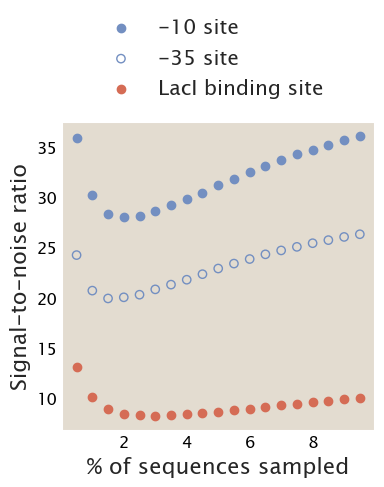

In [13]:
fig, ax = plt.subplots(figsize=(4, 5.5))
ax.scatter(percentage * 100, rs_stn_ratio_rnap10, label='-10 site', color='#738FC1')
ax.scatter(percentage * 100, rs_stn_ratio_rnap35, label='-35 site', facecolors='none', edgecolors='#738FC1', )
ax.scatter(percentage * 100, rs_stn_ratio_lacI, label='LacI binding site',
           color='#D56C55')
ax.set_xlabel('% of sequences sampled', fontsize=16)
ax.set_ylabel('Signal-to-noise ratio',fontsize=16)
ax.legend(bbox_to_anchor=(0.9, 1.4), frameon=False, fontsize=15)

plt.tight_layout()
plt.savefig(out_fdir + 'random_sampling.pdf', bbox_inches='tight')

### 3. Example information footprint with experimental noise

For comparison, we first simulate a footprint with no experimental noise.

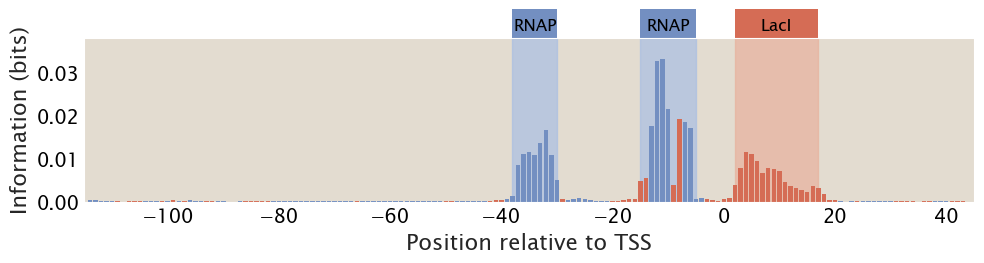

In [14]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile=out_fdir + 'footprint_no_noise.pdf')

Next, we simulate an information footprint with noise from 30 rounds of PCR amplication.

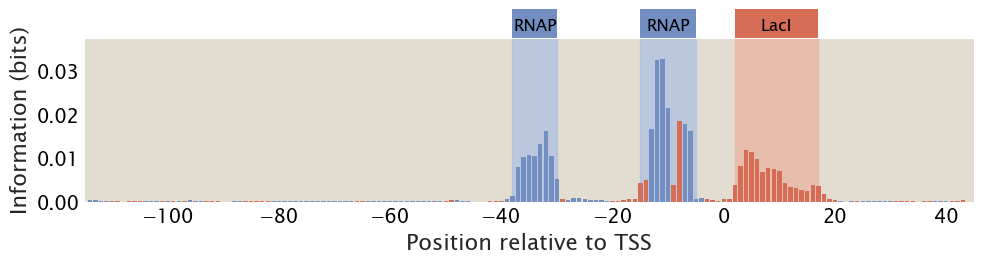

In [15]:
rounds = 30

df['ct_1_amplified'] = df.apply(lambda row: append_amplified_count(row['ct_1'], rounds), axis=1)
df['ct_1_amplified'] = df['ct_1_amplified'] / max(df['ct_1_amplified']) * 10**4
df['norm_ct_1'] = df['ct_1_amplified'] / df['ct_0']

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               outfile=out_fdir + 'pcr_amplification_fp.pdf')

We also simulate an information footprint with noise from random sampling effects.

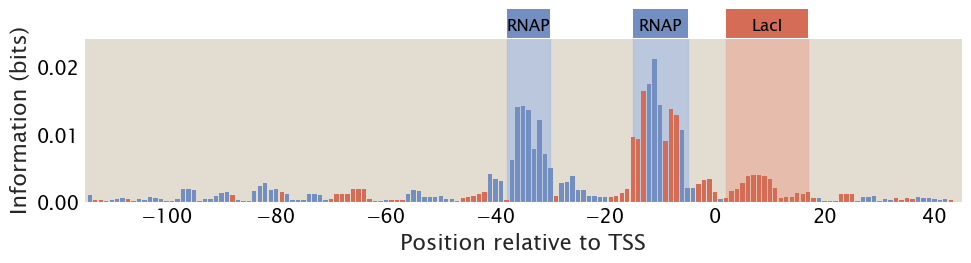

In [16]:
n_NS = len(genome)
n_p = 5000
n_r = 10
ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, tregs.simulate.simrep_pbound, [rnap_site, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

df_random = random_sampling(df, n=int(np.sum(df['ct_1'])*0.005))

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df_random, region_params,
                               outfile=out_fdir + 'random_sampling_fp.pdf')